In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir_m.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [5]:
stir.index = stir['TIME']

In [6]:
stir = stir[['Value']].copy()

In [7]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [8]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [9]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [10]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [11]:
inf_l = inf_l[:-8]

In [12]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [13]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [14]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%m') + relativedelta(months=i))

In [15]:
infr = pd.DataFrame([inf_l, date_list], index=['Value', 'date']).T.iloc[:-4, :]

#### Unemployment

In [16]:
umpr = pd.read_csv('var_ru/ru_unemployment.csv')

In [17]:
umpr = umpr[['date', 'fact']].sort_index(axis=0, ascending=False).reset_index(drop=True).copy()

In [18]:
ump_l = umpr['fact'].tolist()[:-1]

In [19]:
for i in range(len(ump_l)):
    ump_l[i] = ump_l[i].replace(',', '.').replace('%', '')
    ump_l[i] = float(ump_l[i])

In [20]:
date_list = []
for i in range(len(ump_l)):
    date_list.append(datetime.strptime('1992-11', '%Y-%m') + relativedelta(months=i))

In [21]:
umpr = pd.DataFrame([ump_l[:-1], date_list], index=['Value', 'date']).T

#### Make full df

In [22]:
umpr.index = umpr['date']
umpr = umpr[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [23]:
df_var_t = pd.concat([umpr, stir, infr], axis=1).dropna()
df_var_t.columns = ['umpr', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                  -1.934407
p-value                          0.316052
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (5%)             -2.874531
Critical Value (1%)             -3.459885
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            1.293213
p-value                   0.010000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


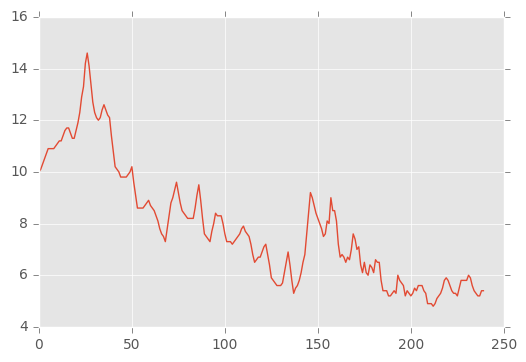

In [24]:
test_stationarity(df_var_t['umpr'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.360835
p-value                          0.153097
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (5%)             -2.874531
Critical Value (1%)             -3.459885
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            0.669004
p-value                   0.016363
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


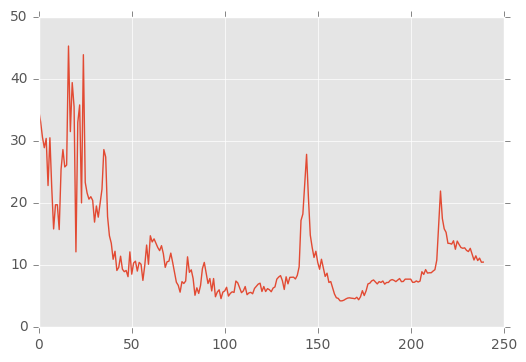

In [25]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                -5.799629e+00
p-value                        4.663731e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (5%)           -2.873814e+00
Critical Value (1%)           -3.458247e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.527277
p-value                   0.035523
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


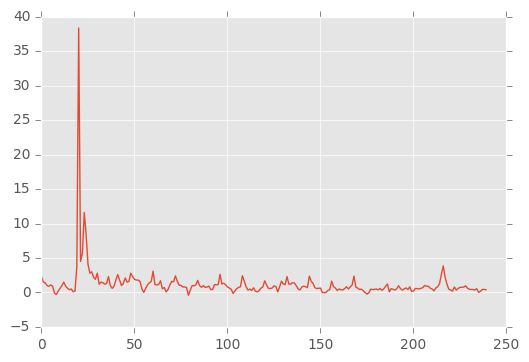

In [26]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                  -3.425170
p-value                          0.010130
#Lags Used                      15.000000
Number of Observations Used    223.000000
Critical Value (5%)             -2.874590
Critical Value (1%)             -3.460019
Critical Value (10%)            -2.573725
dtype: float64


Results of KPSS Test:
Test Statistic            0.051855
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


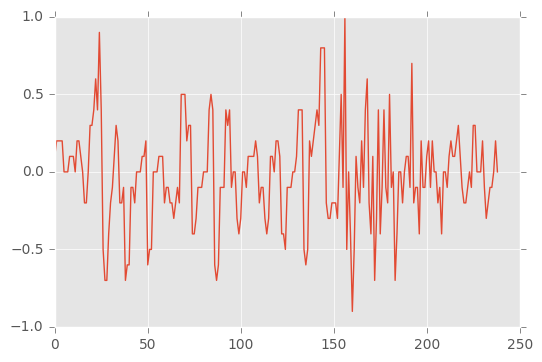

In [27]:
test_stationarity(diff_series(df_var_t['umpr']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.087974
p-value                          0.000015
#Lags Used                      11.000000
Number of Observations Used    227.000000
Critical Value (5%)             -2.874358
Critical Value (1%)             -3.459490
Critical Value (10%)            -2.573602
dtype: float64


Results of KPSS Test:
Test Statistic            0.215061
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


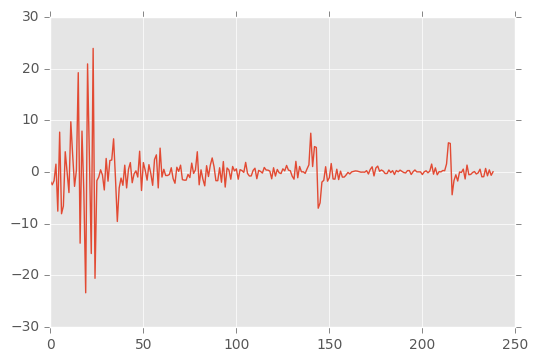

In [28]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -1.462021e+01
p-value                        3.895774e-27
#Lags Used                     2.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (5%)           -2.873866e+00
Critical Value (1%)           -3.458366e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.031833
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


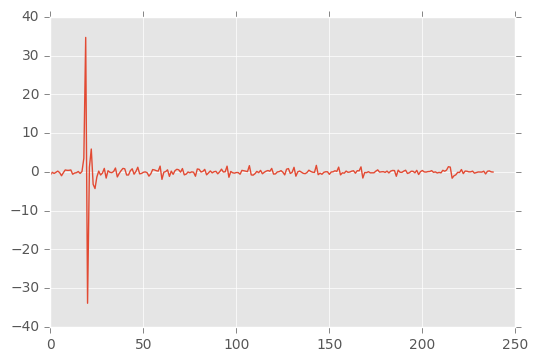

In [29]:
test_stationarity(diff_series(df_var_t['infr']))

In [30]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [31]:
STEPS = 6
LAG = 4

In [32]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [33]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [34]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='m')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mse': 0.56788002652023262, 'rmse': 0.75357814891372255, 'mae': 0.62843069848110478}
{'mse': 0.26276021651365283, 'rmse': 0.51260142070974879, 'mae': 0.40976795929389703}
{'mse': 0.0064717555325802664, 'rmse': 0.08044722203146773, 'mae': 0.056943005893196598}


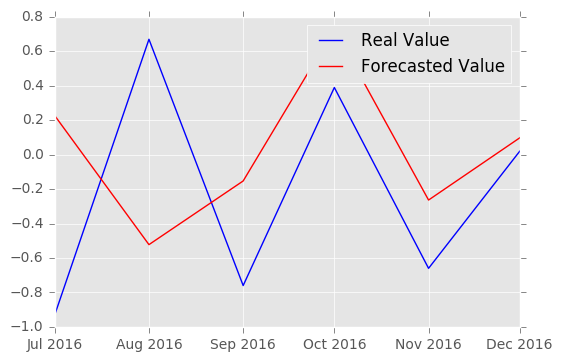

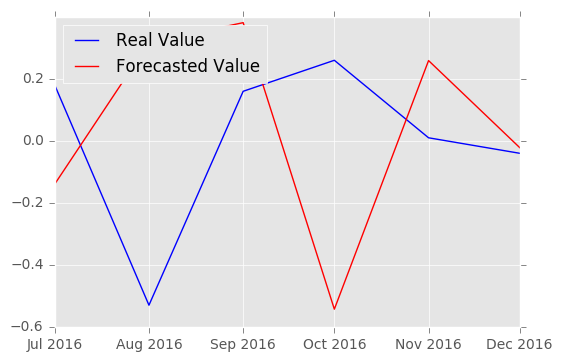

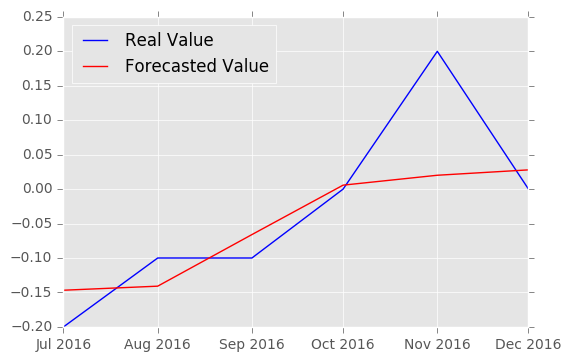

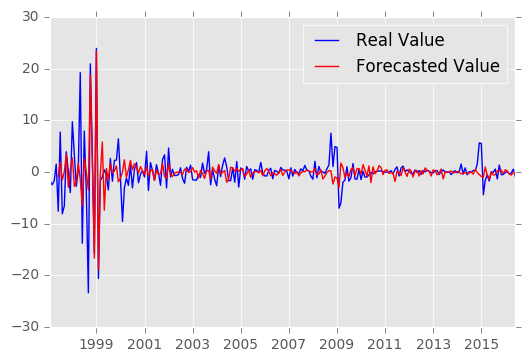

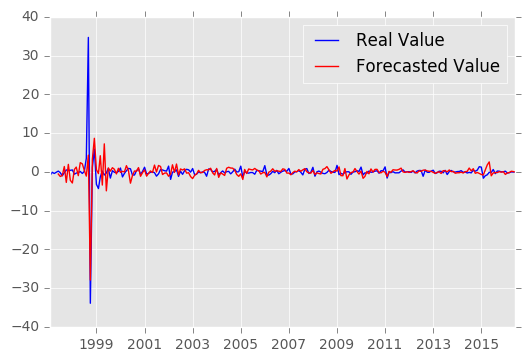

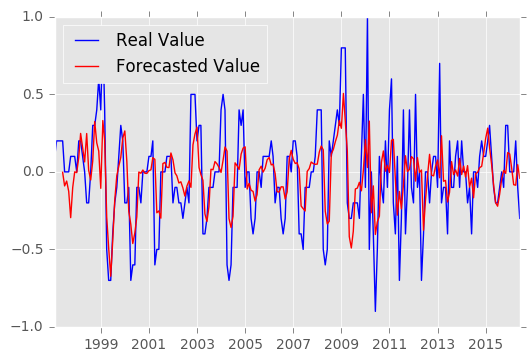

In [35]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

{'mse': 1.0214637545951868, 'rmse': 1.0106749005467519, 'mae': 0.89493416767097089}
{'mse': 0.17168708890027529, 'rmse': 0.4143514075036735, 'mae': 0.34341461504326909}
{'mse': 0.0056920287048749692, 'rmse': 0.075445534691424704, 'mae': 0.065272443500792754}


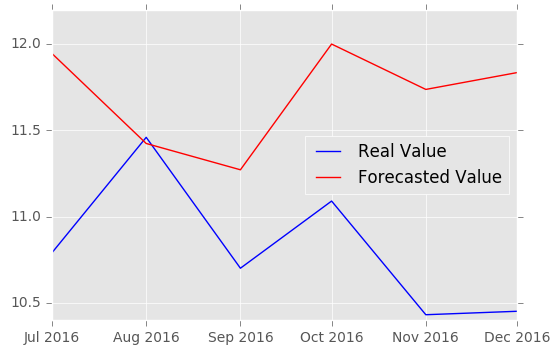

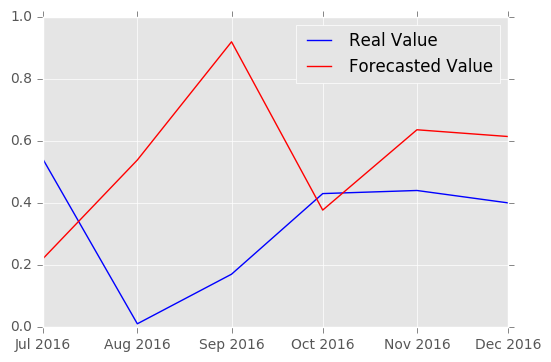

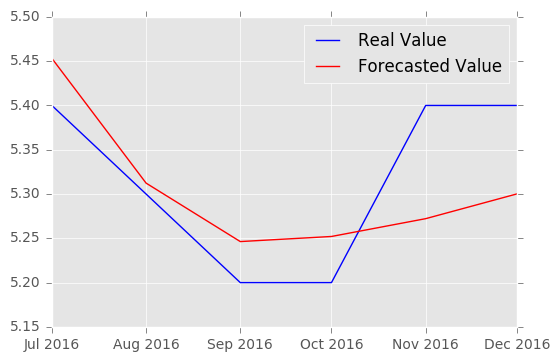

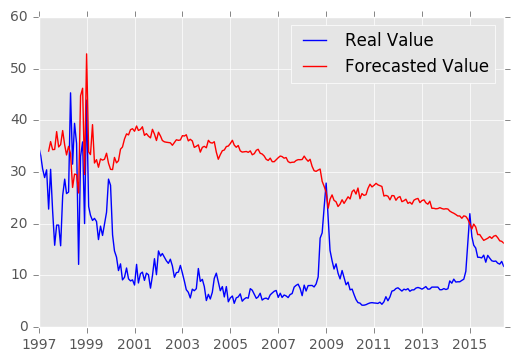

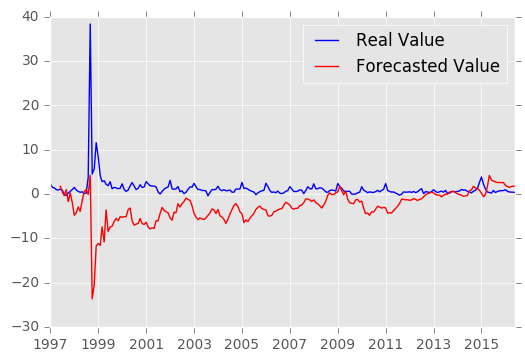

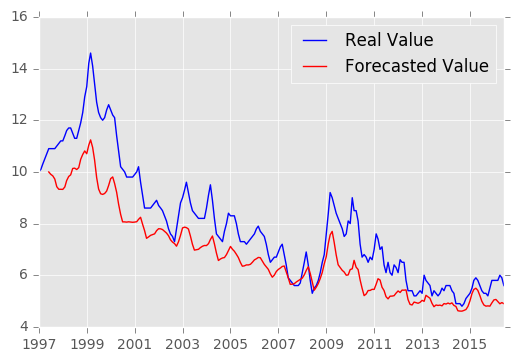

In [36]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

## ANN

In [37]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [38]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='m'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [39]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [40]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
1s - loss: 1.0510
Epoch 2/500
0s - loss: 1.0013
Epoch 3/500
0s - loss: 0.9876
Epoch 4/500
0s - loss: 0.9754
Epoch 5/500
0s - loss: 0.9671
Epoch 6/500
0s - loss: 0.9573
Epoch 7/500
0s - loss: 0.9472
Epoch 8/500
0s - loss: 0.9373
Epoch 9/500
0s - loss: 0.9280
Epoch 10/500
0s - loss: 0.9178
Epoch 11/500
0s - loss: 0.9085
Epoch 12/500
0s - loss: 0.9011
Epoch 13/500
0s - loss: 0.8922
Epoch 14/500
0s - loss: 0.8867
Epoch 15/500
0s - loss: 0.8792
Epoch 16/500
0s - loss: 0.8691
Epoch 17/500
0s - loss: 0.8627
Epoch 18/500
0s - loss: 0.8544
Epoch 19/500
0s - loss: 0.8477
Epoch 20/500
0s - loss: 0.8448
Epoch 21/500
0s - loss: 0.8348
Epoch 22/500
0s - loss: 0.8307
Epoch 23/500
0s - loss: 0.8238
Epoch 24/500
0s - loss: 0.8183
Epoch 25/500
0s - loss: 0.8129
Epoch 26/500
0s - loss: 0.8076
Epoch 27/500
0s - loss: 0.8016
Epoch 28/500
0s - loss: 0.7963
Epoch 29/500
0s - loss: 0.7925
Epoch 30/500
0s - loss: 0.7873
Epoch 31/500
0s - loss: 0.7844
Epoch 32/500
0s - loss: 0.7820
Epoch 33/500
0s -

{'mse': 2.5053906210554477, 'rmse': 1.5828425762075797, 'mae': 1.3876022172793723}
{'mse': 1.3908065733071295, 'rmse': 1.1793246259224512, 'mae': 0.94152515246107038}
{'mse': 0.03663492074413683, 'rmse': 0.19140250976446685, 'mae': 0.16457400183040469}


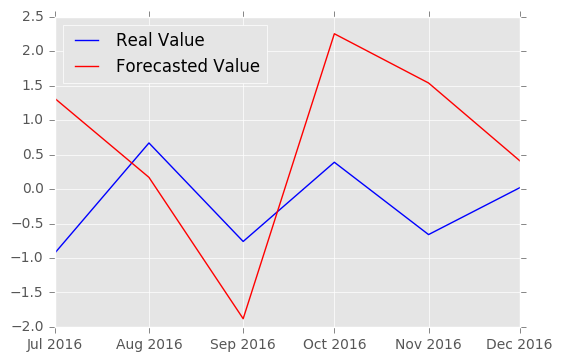

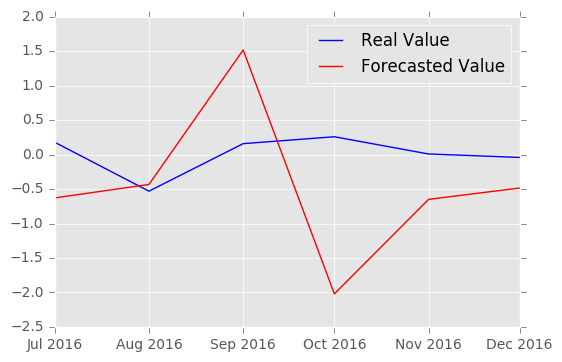

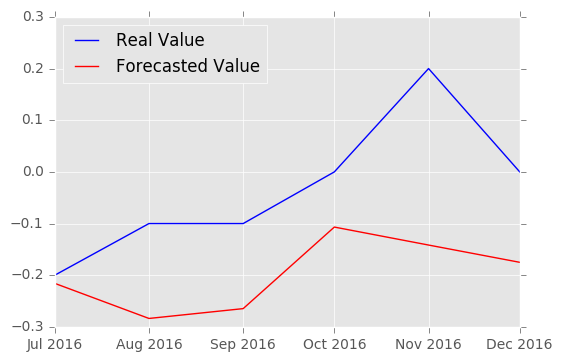

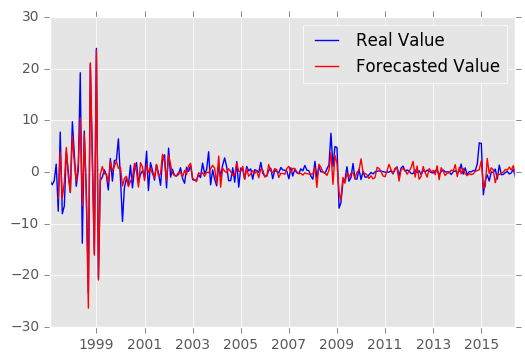

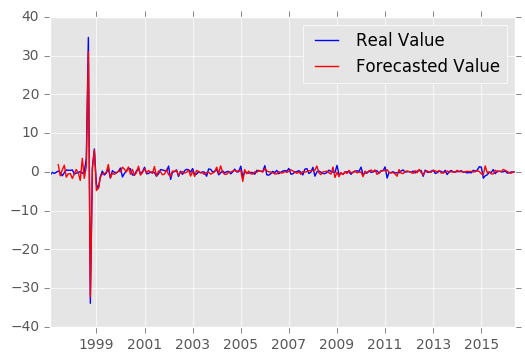

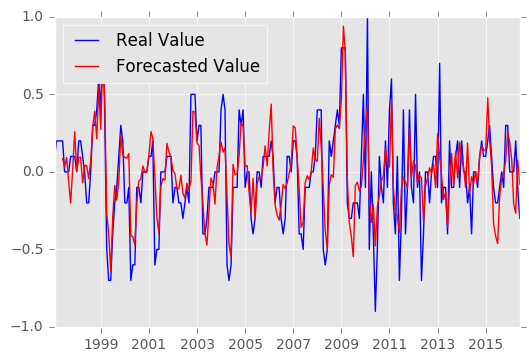

In [41]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 10.431554528021508, 'rmse': 3.2297917158884268, 'mae': 2.8154535015971951}
{'mse': 2.8260510521573479, 'rmse': 1.6810862714796488, 'mae': 1.4703751590371936}
{'mse': 0.33822000576758421, 'rmse': 0.58156685408264475, 'mae': 0.47498171322222199}


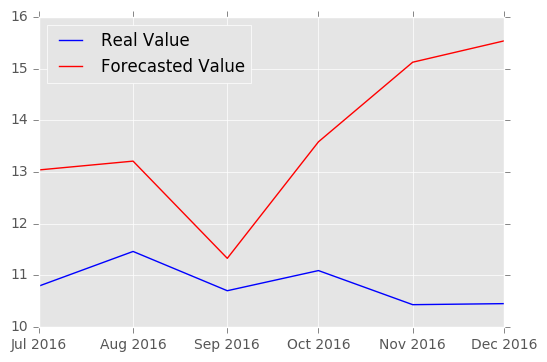

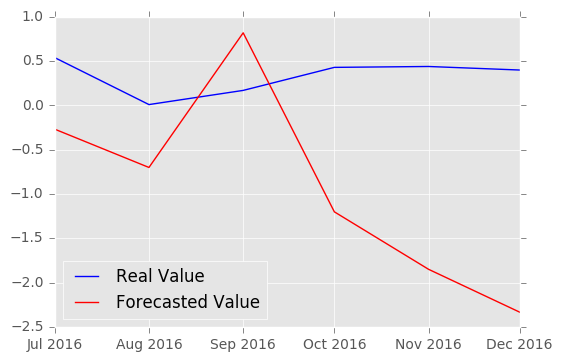

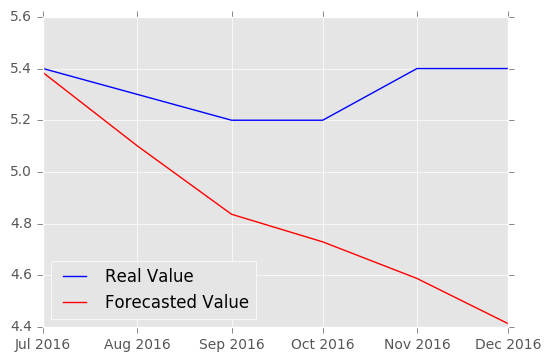

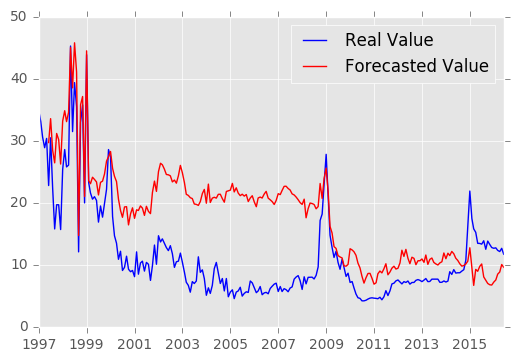

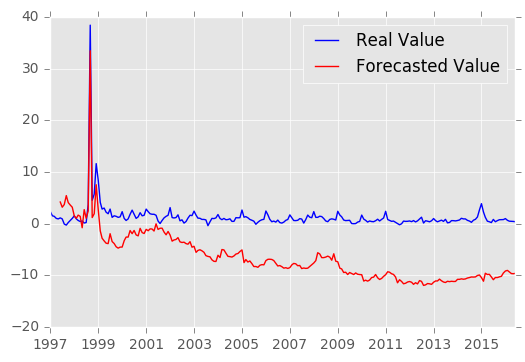

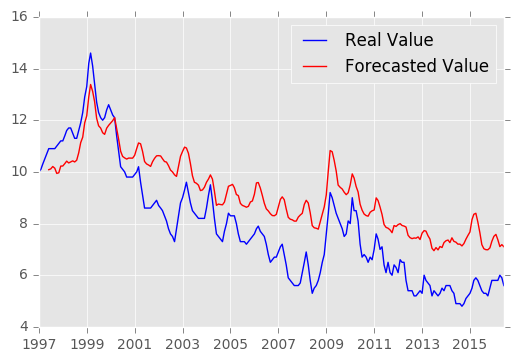

In [42]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск

In [43]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0151
Epoch 2/600
0s - loss: 0.9899
Epoch 3/600
0s - loss: 0.9782
Epoch 4/600
0s - loss: 0.9676
Epoch 5/600
0s - loss: 0.9549
Epoch 6/600
0s - loss: 0.9460
Epoch 7/600
0s - loss: 0.9330
Epoch 8/600
0s - loss: 0.9221
Epoch 9/600
0s - loss: 0.9122
Epoch 10/600
0s - loss: 0.9013
Epoch 11/600
0s - loss: 0.8919
Epoch 12/600
0s - loss: 0.8826
Epoch 13/600
0s - loss: 0.8724
Epoch 14/600
0s - loss: 0.8660
Epoch 15/600
0s - loss: 0.8566
Epoch 16/600
0s - loss: 0.8467
Epoch 17/600
0s - loss: 0.8417
Epoch 18/600
0s - loss: 0.8353
Epoch 19/600
0s - loss: 0.8260
Epoch 20/600
0s - loss: 0.8225
Epoch 21/600
0s - loss: 0.8183
Epoch 22/600
0s - loss: 0.8084
Epoch 23/600
0s - loss: 0.8063
Epoch 24/600
0s - loss: 0.7985
Epoch 25/600
0s - loss: 0.7956
Epoch 26/600
0s - loss: 0.7914
Epoch 27/600
0s - loss: 0.7860
Epoch 28/600
0s - loss: 0.7801
Epoch 29/600
0s - loss: 0.7751
Epoch 30/600
0s - loss: 0.7711
Epoch 31/600
0s - loss: 0.7674
Epoch 32/600
0s - loss: 0.7622
Epoch 33/600
0s -

{'mse': 13.352190818884784, 'rmse': 3.6540649719024954, 'mae': 2.9009742485043817}
{'mse': 0.64994949630424537, 'rmse': 0.80619445315894189, 'mae': 0.63762190509401295}
{'mse': 0.11528614046296164, 'rmse': 0.33953812814316103, 'mae': 0.29690599935867662}


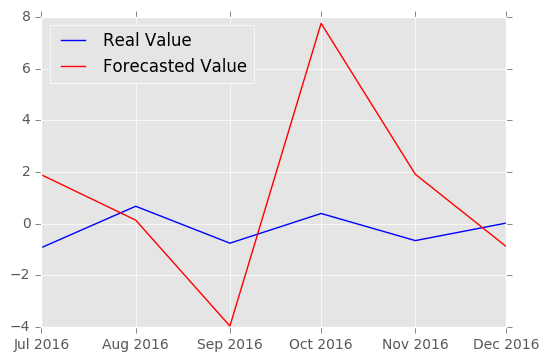

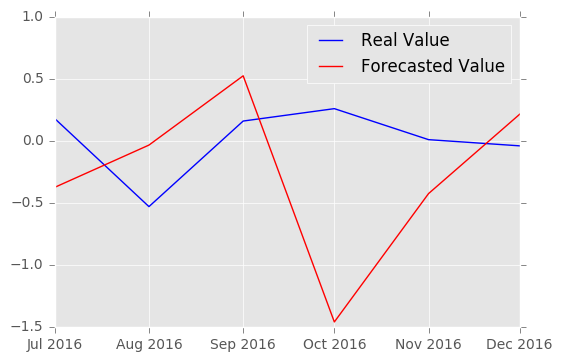

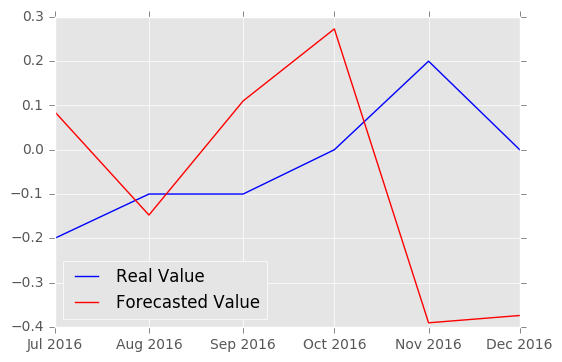

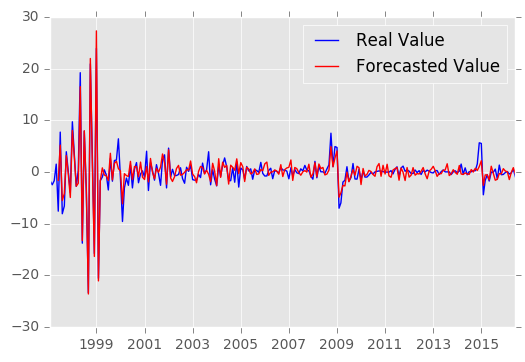

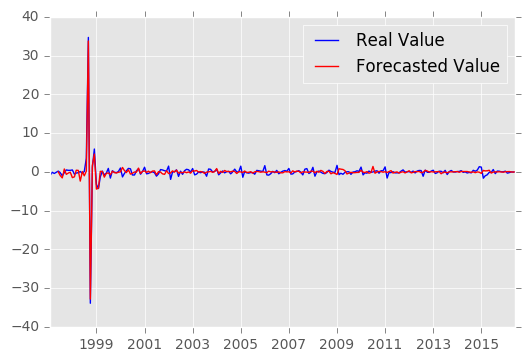

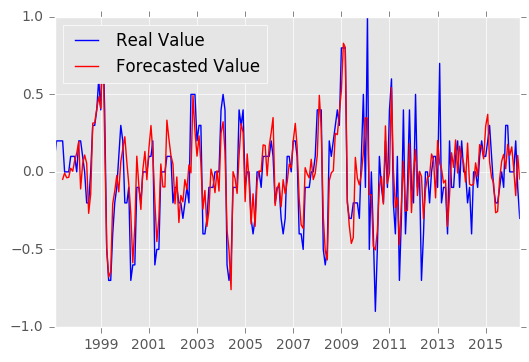

In [44]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 33.62021465709919, 'rmse': 5.7982941161258106, 'mae': 4.9234269867543548}
{'mse': 1.3929386633982332, 'rmse': 1.1802282251320011, 'mae': 0.962399359335112}
{'mse': 0.15611124049345243, 'rmse': 0.39510915010089609, 'mae': 0.34475140475652638}


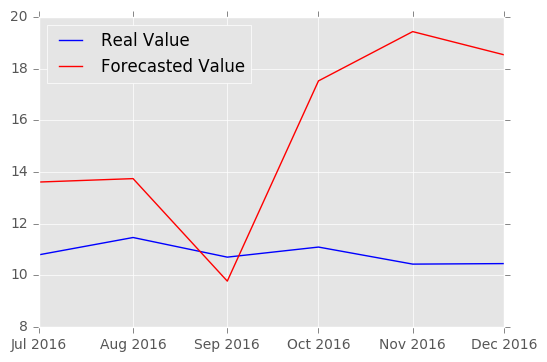

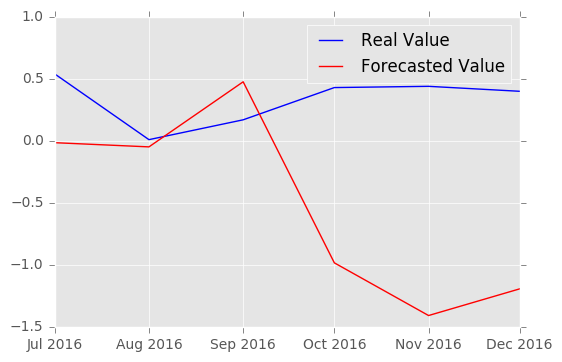

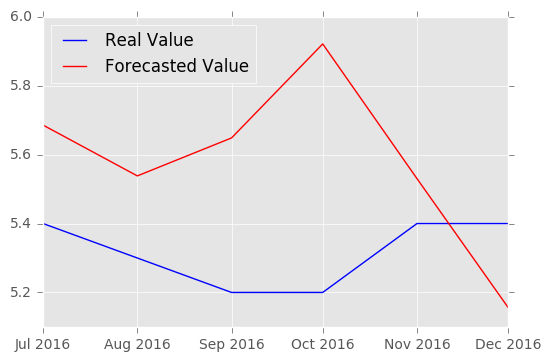

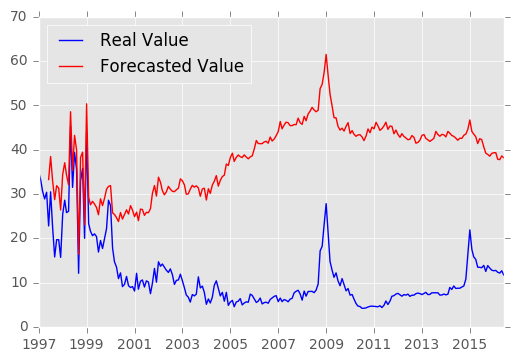

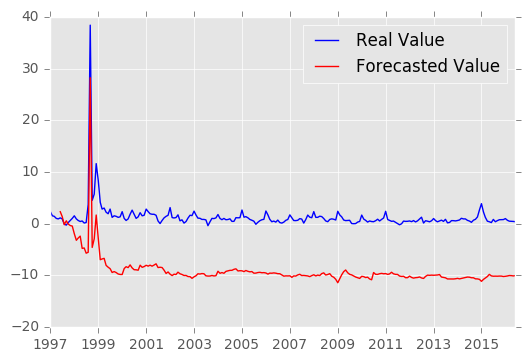

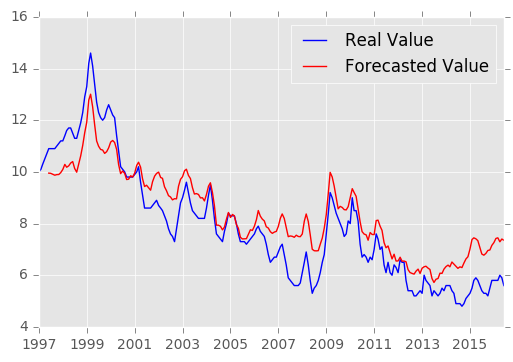

In [45]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

С DropOut

In [46]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
1s - loss: 1.0409
Epoch 2/600
0s - loss: 1.0062
Epoch 3/600
0s - loss: 1.0028
Epoch 4/600
0s - loss: 1.0137
Epoch 5/600
0s - loss: 0.9927
Epoch 6/600
0s - loss: 0.9940
Epoch 7/600
0s - loss: 1.0080
Epoch 8/600
0s - loss: 1.0036
Epoch 9/600
0s - loss: 0.9988
Epoch 10/600
0s - loss: 1.0104
Epoch 11/600
0s - loss: 0.9930
Epoch 12/600
0s - loss: 0.9988
Epoch 13/600
0s - loss: 0.9942
Epoch 14/600
0s - loss: 0.9992
Epoch 15/600
0s - loss: 0.9926
Epoch 16/600
0s - loss: 0.9872
Epoch 17/600
0s - loss: 0.9773
Epoch 18/600
0s - loss: 0.9741
Epoch 19/600
0s - loss: 0.9766
Epoch 20/600
0s - loss: 0.9626
Epoch 21/600
0s - loss: 0.9594
Epoch 22/600
0s - loss: 0.9593
Epoch 23/600
0s - loss: 0.9553
Epoch 24/600
0s - loss: 0.9664
Epoch 25/600
0s - loss: 0.9581
Epoch 26/600
0s - loss: 0.9629
Epoch 27/600
0s - loss: 0.9364
Epoch 28/600
0s - loss: 0.9530
Epoch 29/600
0s - loss: 0.9495
Epoch 30/600
0s - loss: 0.9489
Epoch 31/600
0s - loss: 0.9360
Epoch 32/600
0s - loss: 0.9397
Epoch 33/600
0s -

{'mse': 0.4114024720474227, 'rmse': 0.64140663548752186, 'mae': 0.55448631139271531}
{'mse': 0.066036906909279505, 'rmse': 0.25697647150912378, 'mae': 0.18480143611218539}
{'mse': 0.013306356689533241, 'rmse': 0.11535318239881048, 'mae': 0.088575644636451567}


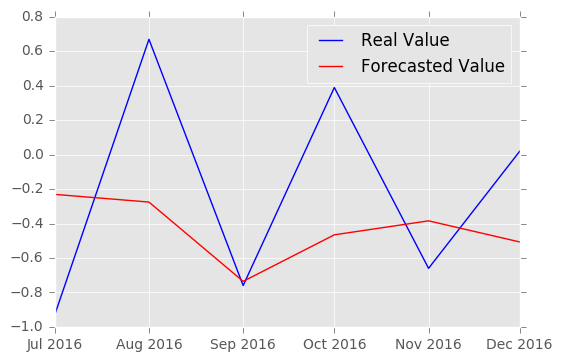

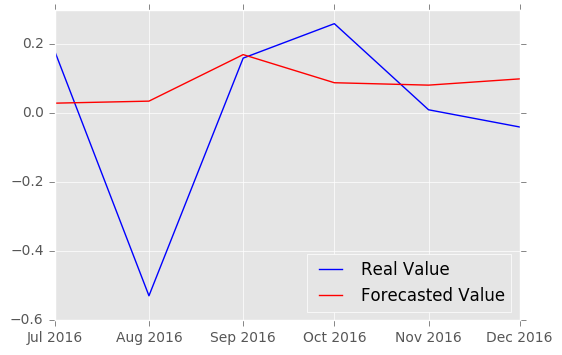

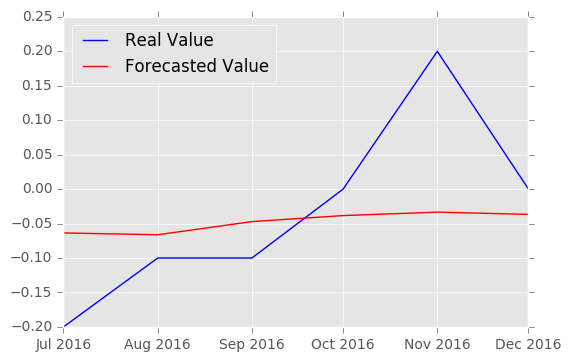

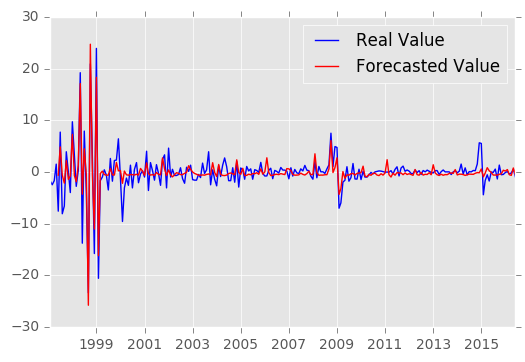

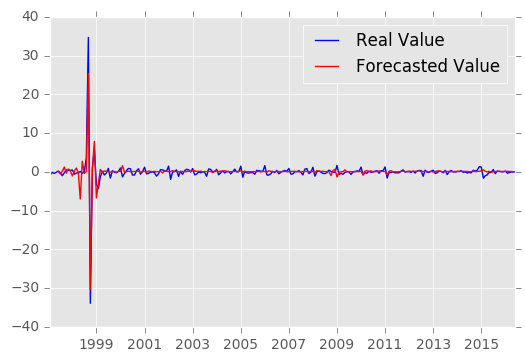

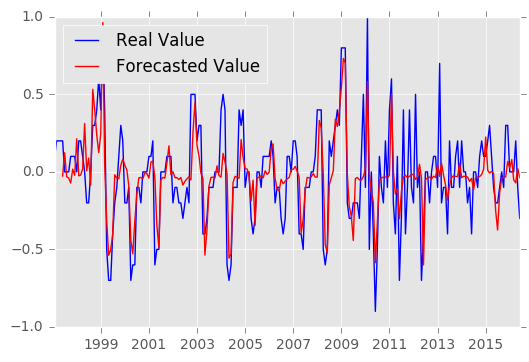

In [47]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 0.69376693390667243, 'rmse': 0.83292672781384103, 'mae': 0.72867347187368914}
{'mse': 0.12654999358713739, 'rmse': 0.35573865911246894, 'mae': 0.33853416783350943}
{'mse': 0.023502747830245193, 'rmse': 0.15330605933962688, 'mae': 0.14140239909740293}


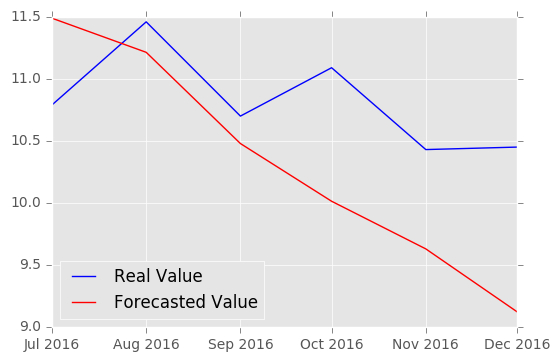

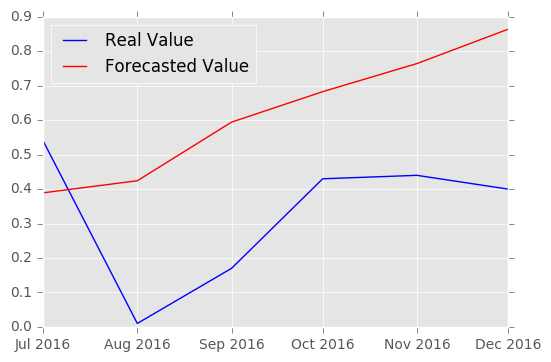

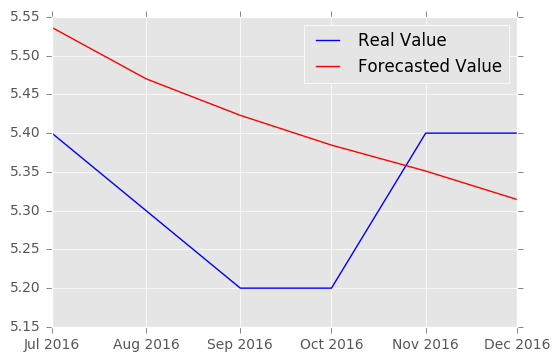

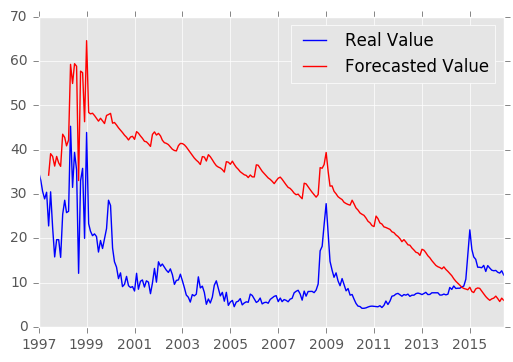

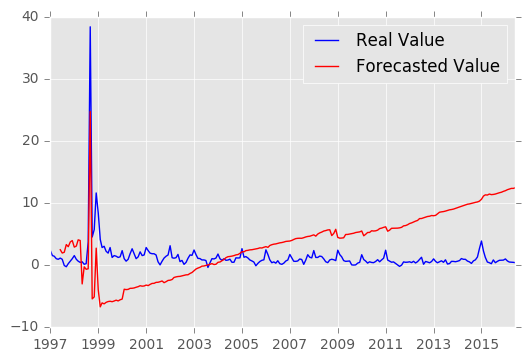

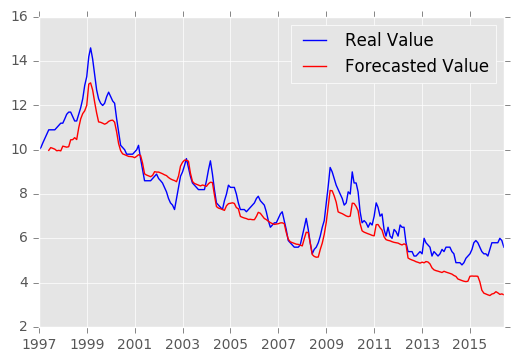

In [48]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

На оригинальных данных, а не разницах

In [49]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [50]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
1s - loss: 0.9448
Epoch 2/600
0s - loss: 0.8226
Epoch 3/600
0s - loss: 0.7272
Epoch 4/600
0s - loss: 0.6446
Epoch 5/600
0s - loss: 0.5813
Epoch 6/600
0s - loss: 0.5362
Epoch 7/600
0s - loss: 0.5023
Epoch 8/600
0s - loss: 0.4751
Epoch 9/600
0s - loss: 0.4545
Epoch 10/600
0s - loss: 0.4393
Epoch 11/600
0s - loss: 0.4261
Epoch 12/600
0s - loss: 0.4153
Epoch 13/600
0s - loss: 0.4076
Epoch 14/600
0s - loss: 0.4009
Epoch 15/600
0s - loss: 0.3945
Epoch 16/600
0s - loss: 0.3902
Epoch 17/600
0s - loss: 0.3849
Epoch 18/600
0s - loss: 0.3847
Epoch 19/600
0s - loss: 0.3792
Epoch 20/600
0s - loss: 0.3773
Epoch 21/600
0s - loss: 0.3745
Epoch 22/600
0s - loss: 0.3728
Epoch 23/600
0s - loss: 0.3719
Epoch 24/600
0s - loss: 0.3695
Epoch 25/600
0s - loss: 0.3682
Epoch 26/600
0s - loss: 0.3672
Epoch 27/600
0s - loss: 0.3656
Epoch 28/600
0s - loss: 0.3646
Epoch 29/600
0s - loss: 0.3631
Epoch 30/600
0s - loss: 0.3627
Epoch 31/600
0s - loss: 0.3617
Epoch 32/600
0s - loss: 0.3599
Epoch 33/600
0s -

{'mse': 22.263437994673563, 'rmse': 4.7184147756077532, 'mae': 4.6336685698678091}
{'mse': 0.037253503440140869, 'rmse': 0.19301166659075525, 'mae': 0.17506544816567179}
{'mse': 1.0066396437512253, 'rmse': 1.003314329485643, 'mae': 0.81074391194668849}


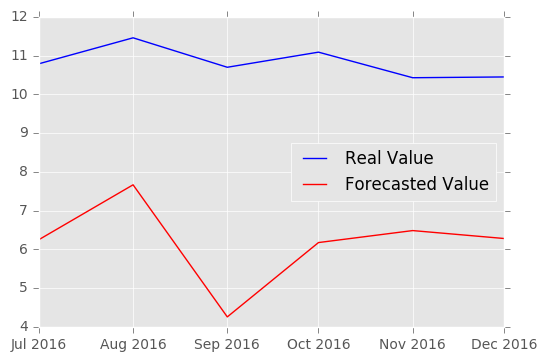

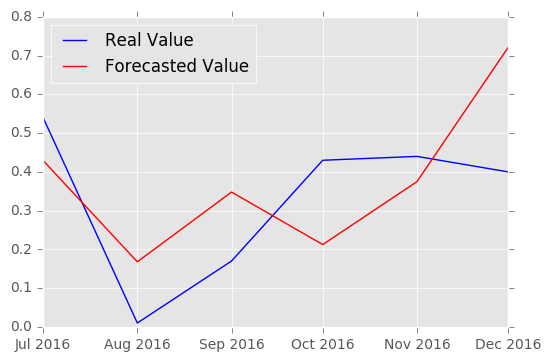

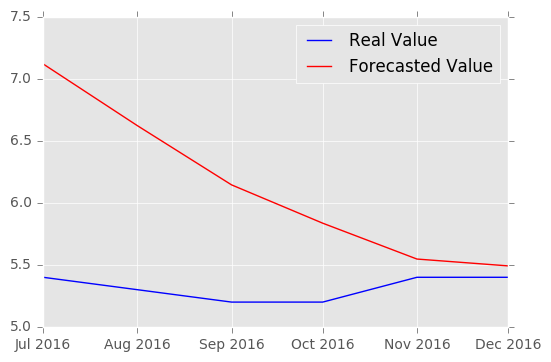

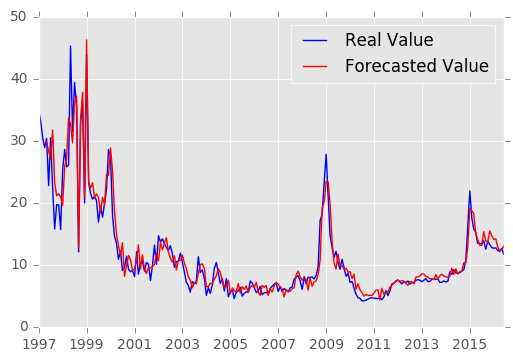

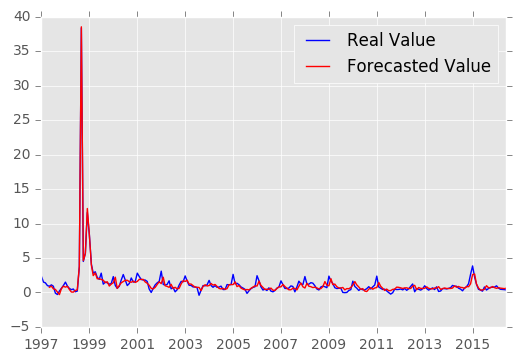

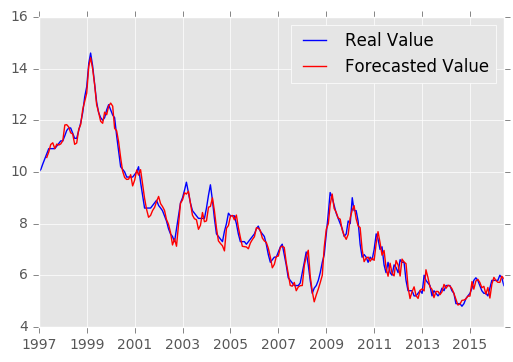

In [51]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

Второй запуск (не на разницах)

In [52]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.1164
Epoch 2/600
0s - loss: 0.8828
Epoch 3/600
0s - loss: 0.7886
Epoch 4/600
0s - loss: 0.6973
Epoch 5/600
0s - loss: 0.6175
Epoch 6/600
0s - loss: 0.5572
Epoch 7/600
0s - loss: 0.5158
Epoch 8/600
0s - loss: 0.4894
Epoch 9/600
0s - loss: 0.4690
Epoch 10/600
0s - loss: 0.4549
Epoch 11/600
0s - loss: 0.4436
Epoch 12/600
0s - loss: 0.4328
Epoch 13/600
0s - loss: 0.4212
Epoch 14/600
0s - loss: 0.4124
Epoch 15/600
0s - loss: 0.4026
Epoch 16/600
1s - loss: 0.3952
Epoch 17/600
0s - loss: 0.3892
Epoch 18/600
0s - loss: 0.3839
Epoch 19/600
0s - loss: 0.3792
Epoch 20/600
0s - loss: 0.3759
Epoch 21/600
0s - loss: 0.3730
Epoch 22/600
0s - loss: 0.3707
Epoch 23/600
0s - loss: 0.3686
Epoch 24/600
0s - loss: 0.3650
Epoch 25/600
0s - loss: 0.3646
Epoch 26/600
0s - loss: 0.3632
Epoch 27/600
0s - loss: 0.3611
Epoch 28/600
0s - loss: 0.3595
Epoch 29/600
0s - loss: 0.3597
Epoch 30/600
0s - loss: 0.3572
Epoch 31/600
0s - loss: 0.3558
Epoch 32/600
0s - loss: 0.3551
Epoch 33/600
0s -

{'mse': 21.281861616025779, 'rmse': 4.6132268116824449, 'mae': 4.538355485984753}
{'mse': 0.13349247708233922, 'rmse': 0.36536622323682194, 'mae': 0.32273232224091924}
{'mse': 2.2223393389801518, 'rmse': 1.4907512666371112, 'mae': 1.48613038399305}


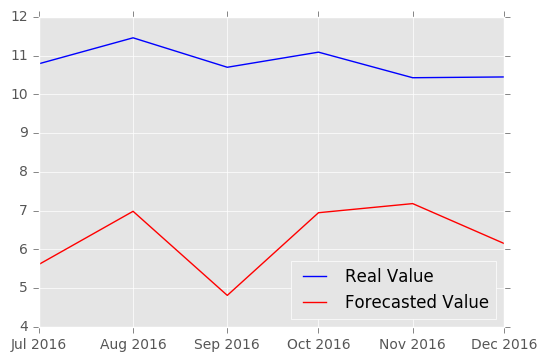

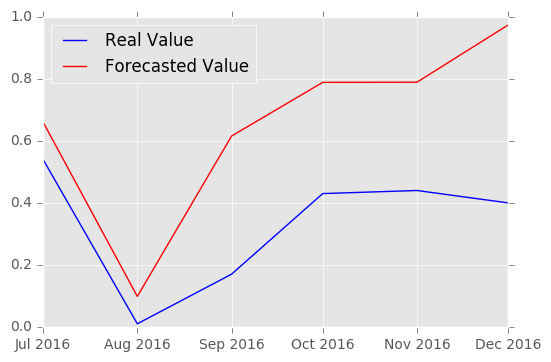

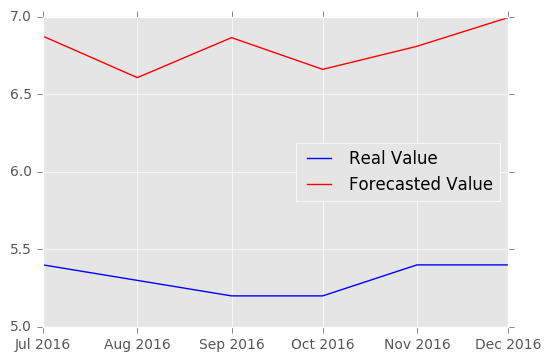

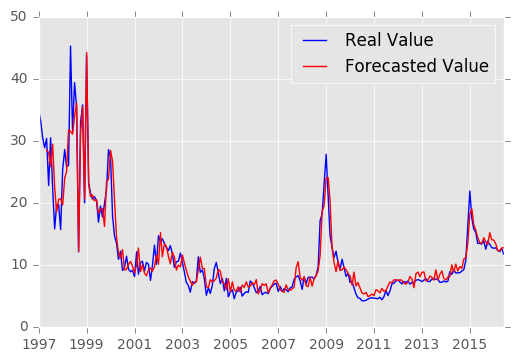

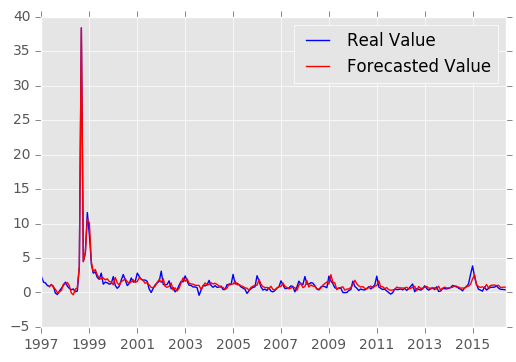

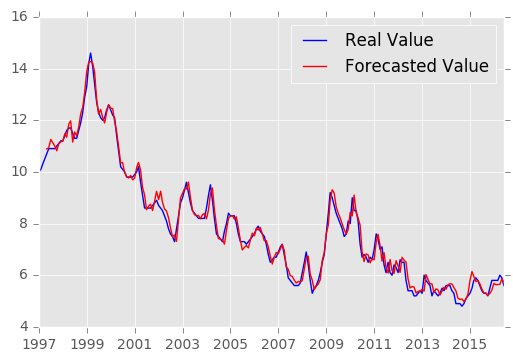

In [53]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

С DropOut

In [54]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.1683
Epoch 2/600
0s - loss: 0.8978
Epoch 3/600
0s - loss: 0.8140
Epoch 4/600
0s - loss: 0.7339
Epoch 5/600
0s - loss: 0.6626
Epoch 6/600
0s - loss: 0.6071
Epoch 7/600
0s - loss: 0.5653
Epoch 8/600
0s - loss: 0.5342
Epoch 9/600
0s - loss: 0.5100
Epoch 10/600
0s - loss: 0.4896
Epoch 11/600
0s - loss: 0.4713
Epoch 12/600
0s - loss: 0.4525
Epoch 13/600
0s - loss: 0.4385
Epoch 14/600
0s - loss: 0.4247
Epoch 15/600
0s - loss: 0.4146
Epoch 16/600
0s - loss: 0.4051
Epoch 17/600
0s - loss: 0.3981
Epoch 18/600
0s - loss: 0.3916
Epoch 19/600
0s - loss: 0.3857
Epoch 20/600
0s - loss: 0.3828
Epoch 21/600
0s - loss: 0.3793
Epoch 22/600
0s - loss: 0.3760
Epoch 23/600
0s - loss: 0.3736
Epoch 24/600
0s - loss: 0.3724
Epoch 25/600
0s - loss: 0.3699
Epoch 26/600
0s - loss: 0.3687
Epoch 27/600
0s - loss: 0.3677
Epoch 28/600
0s - loss: 0.3659
Epoch 29/600
0s - loss: 0.3656
Epoch 30/600
0s - loss: 0.3639
Epoch 31/600
0s - loss: 0.3633
Epoch 32/600
0s - loss: 0.3619
Epoch 33/600
0s -

{'mse': 20.651691718622263, 'rmse': 4.5444132425014194, 'mae': 4.4982702479857339}
{'mse': 0.03532570842476327, 'rmse': 0.18795134589771703, 'mae': 0.14481852578451815}
{'mse': 1.2473011190269563, 'rmse': 1.1168263602847832, 'mae': 1.0884633886196704}


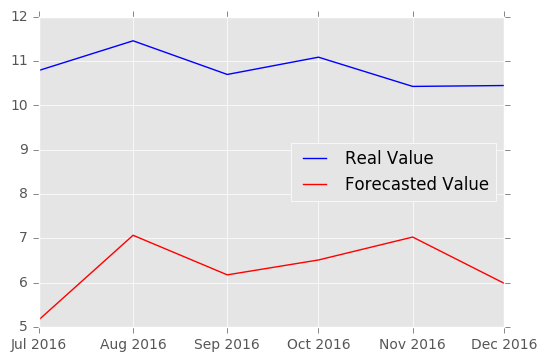

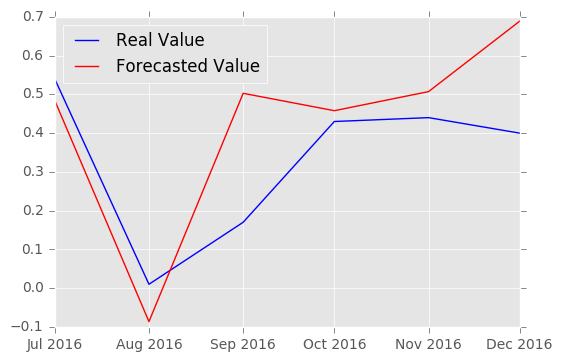

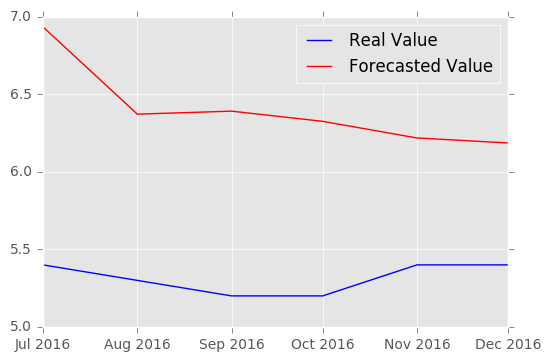

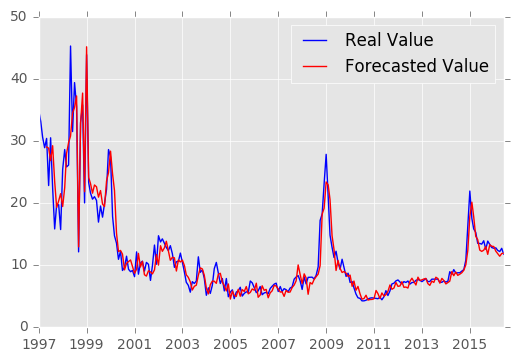

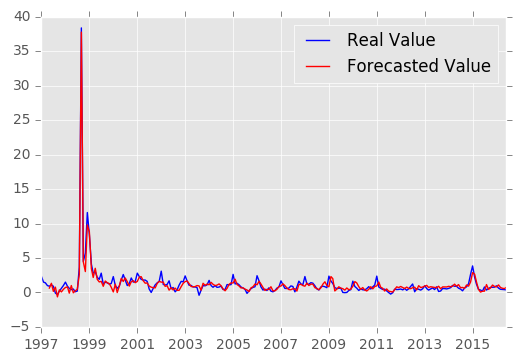

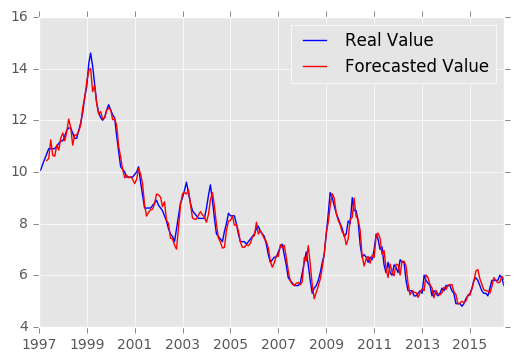

In [55]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

## Hybrid

In [56]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [57]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [58]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0569
Epoch 2/200
0s - loss: 1.0048
Epoch 3/200
0s - loss: 1.0012
Epoch 4/200
0s - loss: 0.9999
Epoch 5/200
0s - loss: 0.9968
Epoch 6/200
0s - loss: 0.9964
Epoch 7/200
0s - loss: 0.9961
Epoch 8/200
0s - loss: 0.9945
Epoch 9/200
0s - loss: 0.9935
Epoch 10/200
0s - loss: 0.9939
Epoch 11/200
0s - loss: 0.9889
Epoch 12/200
0s - loss: 0.9883
Epoch 13/200
0s - loss: 0.9876
Epoch 14/200
0s - loss: 0.9864
Epoch 15/200
0s - loss: 0.9865
Epoch 16/200
0s - loss: 0.9849
Epoch 17/200
0s - loss: 0.9835
Epoch 18/200
0s - loss: 0.9811
Epoch 19/200
0s - loss: 0.9781
Epoch 20/200
0s - loss: 0.9774
Epoch 21/200
0s - loss: 0.9758
Epoch 22/200
0s - loss: 0.9755
Epoch 23/200
0s - loss: 0.9748
Epoch 24/200
0s - loss: 0.9710
Epoch 25/200
0s - loss: 0.9696
Epoch 26/200
0s - loss: 0.9697
Epoch 27/200
0s - loss: 0.9648
Epoch 28/200
0s - loss: 0.9635
Epoch 29/200
0s - loss: 0.9617
Epoch 30/200
0s - loss: 0.9606
Epoch 31/200
0s - loss: 0.9582
Epoch 32/200
0s - loss: 0.9567
Epoch 33/200
0s -

{'mse': 0.72007396080256525, 'rmse': 0.8485717181255602, 'mae': 0.72231234099268848}
{'mse': 0.60648797001316523, 'rmse': 0.77877337525955859, 'mae': 0.75411832337447338}
{'mse': 0.0099656425578069797, 'rmse': 0.099828064980780729, 'mae': 0.087818248887359618}


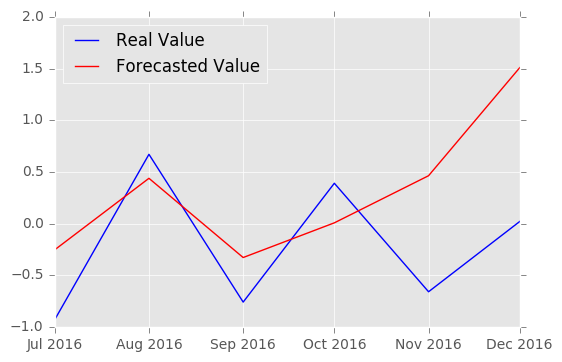

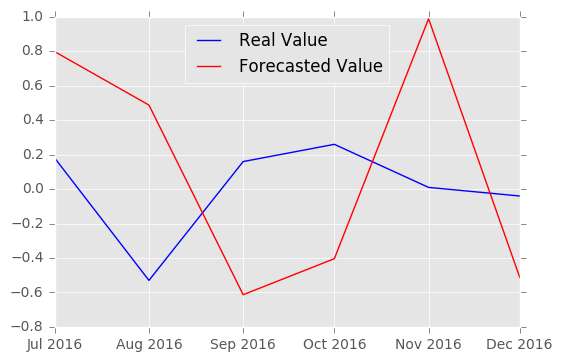

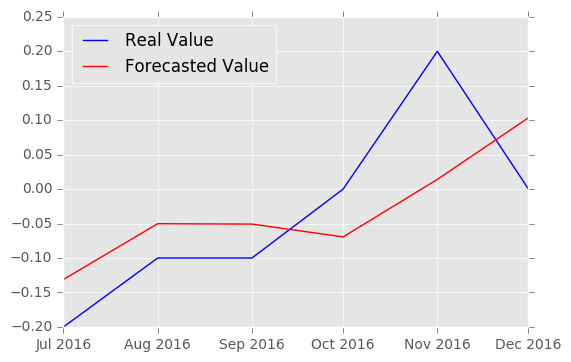

In [59]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 2.3172662075651829, 'rmse': 1.5222569453167829, 'mae': 1.2010117331562347}
{'mse': 0.95469912921329936, 'rmse': 0.97708706327189665, 'mae': 0.86656478615188026}
{'mse': 0.010774549557157578, 'rmse': 0.10380052773063141, 'mae': 0.092945002993477743}


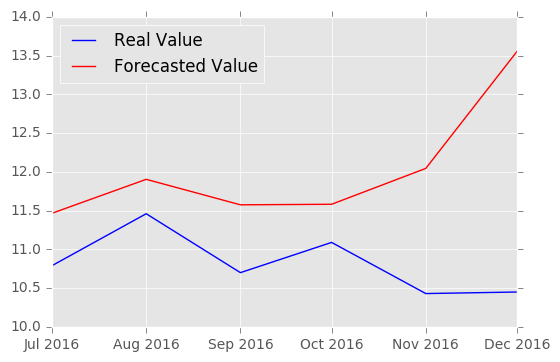

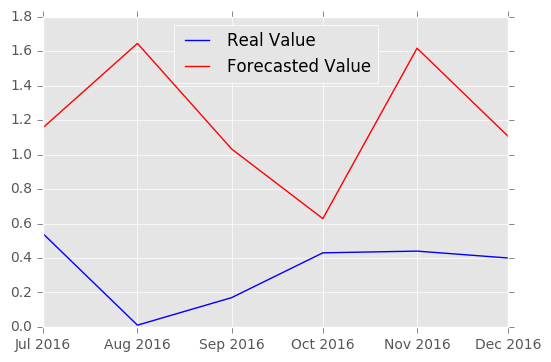

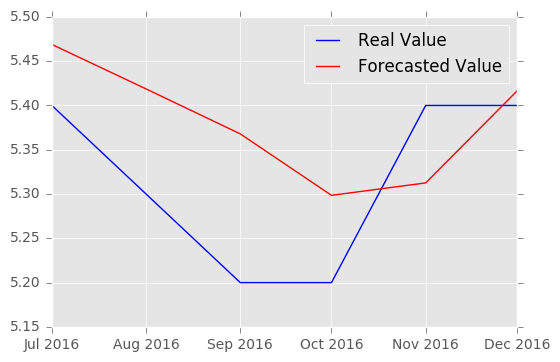

In [60]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [61]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0813
Epoch 2/200
0s - loss: 1.0057
Epoch 3/200
0s - loss: 1.0038
Epoch 4/200
0s - loss: 1.0013
Epoch 5/200
0s - loss: 1.0012
Epoch 6/200
0s - loss: 0.9970
Epoch 7/200
0s - loss: 0.9967
Epoch 8/200
0s - loss: 0.9963
Epoch 9/200
0s - loss: 0.9946
Epoch 10/200
0s - loss: 0.9914
Epoch 11/200
0s - loss: 0.9909
Epoch 12/200
0s - loss: 0.9886
Epoch 13/200
0s - loss: 0.9863
Epoch 14/200
0s - loss: 0.9841
Epoch 15/200
0s - loss: 0.9824
Epoch 16/200
0s - loss: 0.9812
Epoch 17/200
0s - loss: 0.9806
Epoch 18/200
0s - loss: 0.9786
Epoch 19/200
0s - loss: 0.9772
Epoch 20/200
0s - loss: 0.9763
Epoch 21/200
0s - loss: 0.9721
Epoch 22/200
0s - loss: 0.9745
Epoch 23/200
0s - loss: 0.9713
Epoch 24/200
0s - loss: 0.9641
Epoch 25/200
0s - loss: 0.9679
Epoch 26/200
0s - loss: 0.9644
Epoch 27/200
0s - loss: 0.9623
Epoch 28/200
0s - loss: 0.9602
Epoch 29/200
0s - loss: 0.9581
Epoch 30/200
0s - loss: 0.9592
Epoch 31/200
0s - loss: 0.9540
Epoch 32/200
0s - loss: 0.9525
Epoch 33/200
0s -

{'mse': 0.77172024776610426, 'rmse': 0.87847609402083571, 'mae': 0.83514817360474991}
{'mse': 0.99305691586148237, 'rmse': 0.99652241111852691, 'mae': 0.72538884783603053}
{'mse': 0.0084826486500338815, 'rmse': 0.092101295593677079, 'mae': 0.075898307992303404}


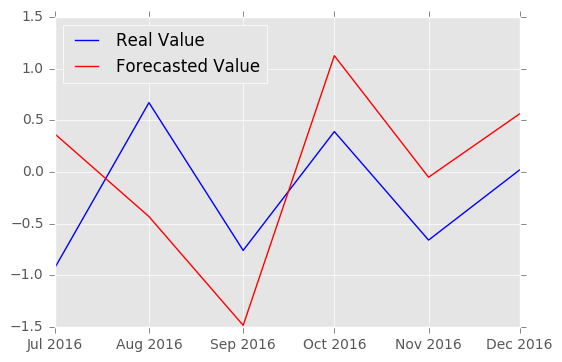

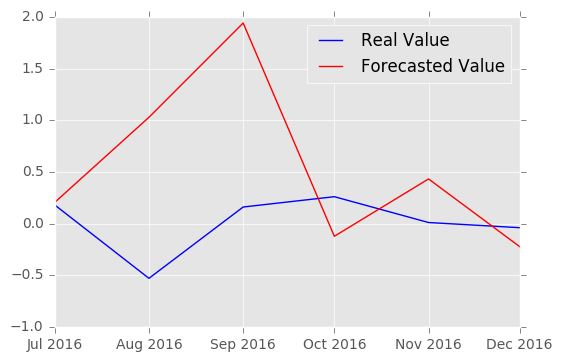

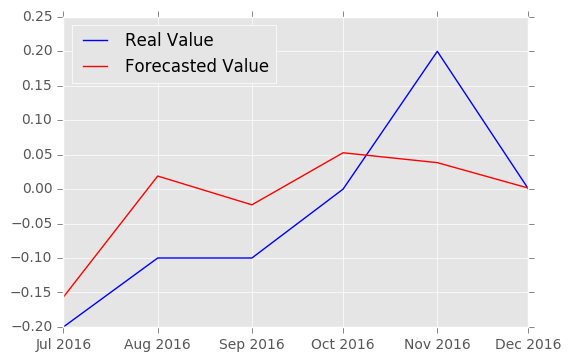

In [62]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 0.75812678687549473, 'rmse': 0.87070476447271994, 'mae': 0.73322653207911015}
{'mse': 7.4417373931756705, 'rmse': 2.727954800427542, 'mae': 2.4291433919419361}
{'mse': 0.034291770177232068, 'rmse': 0.18518037200856918, 'mae': 0.16680964045743307}


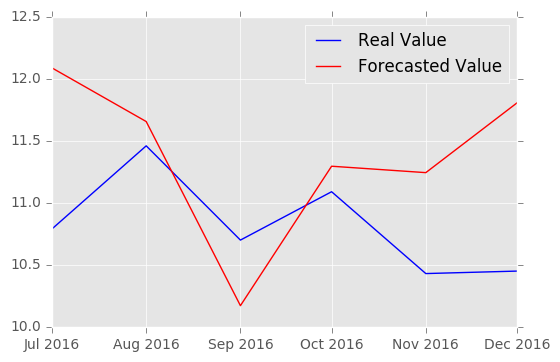

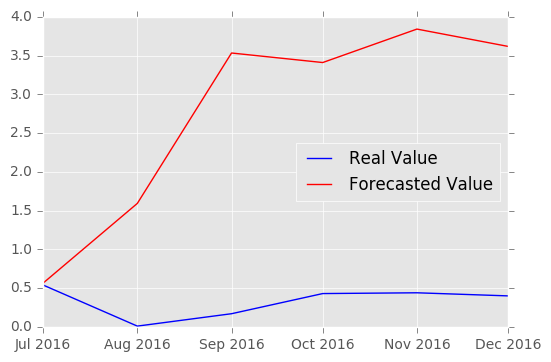

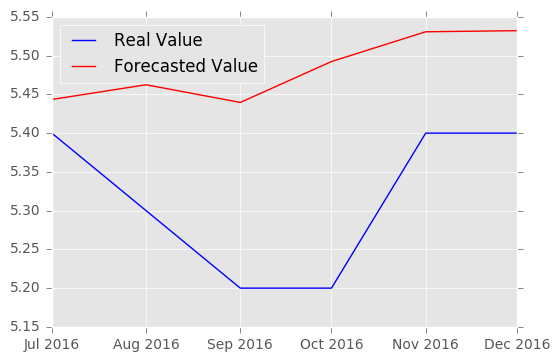

In [63]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0361
Epoch 2/200
0s - loss: 1.0299
Epoch 3/200
0s - loss: 1.0091
Epoch 4/200
0s - loss: 1.0133
Epoch 5/200
0s - loss: 1.0097
Epoch 6/200
0s - loss: 1.0191
Epoch 7/200
0s - loss: 1.0185
Epoch 8/200
0s - loss: 1.0076
Epoch 9/200
0s - loss: 1.0071
Epoch 10/200
0s - loss: 1.0020
Epoch 11/200
0s - loss: 1.0051
Epoch 12/200
0s - loss: 0.9960
Epoch 13/200
0s - loss: 1.0048
Epoch 14/200
0s - loss: 1.0117
Epoch 15/200
0s - loss: 1.0033
Epoch 16/200
0s - loss: 1.0046
Epoch 17/200
0s - loss: 0.9954
Epoch 18/200
0s - loss: 0.9982
Epoch 19/200
0s - loss: 0.9990
Epoch 20/200
0s - loss: 0.9988
Epoch 21/200
0s - loss: 1.0017
Epoch 22/200
0s - loss: 0.9997
Epoch 23/200
0s - loss: 0.9992
Epoch 24/200
0s - loss: 1.0011
Epoch 25/200
0s - loss: 0.9929
Epoch 26/200
0s - loss: 0.9988
Epoch 27/200
0s - loss: 0.9976
Epoch 28/200
0s - loss: 0.9882
Epoch 29/200
0s - loss: 0.9902
Epoch 30/200
0s - loss: 0.9987
Epoch 31/200
0s - loss: 0.9991
Epoch 32/200
0s - loss: 1.0063
Epoch 33/200
0s -

{'mse': 0.58447020317630582, 'rmse': 0.76450650957091648, 'mae': 0.70233227171883372}
{'mse': 0.19859813514751642, 'rmse': 0.44564350679384573, 'mae': 0.36770535475919686}
{'mse': 0.0062579498988744701, 'rmse': 0.079107205100891226, 'mae': 0.055369246682173634}


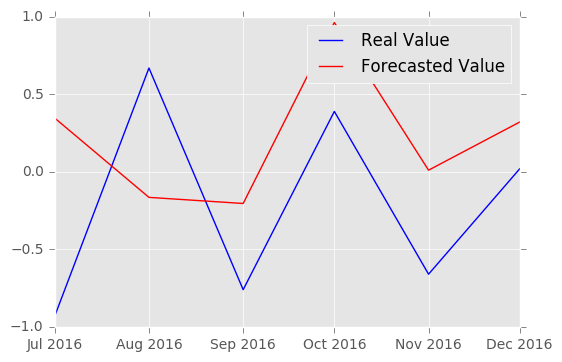

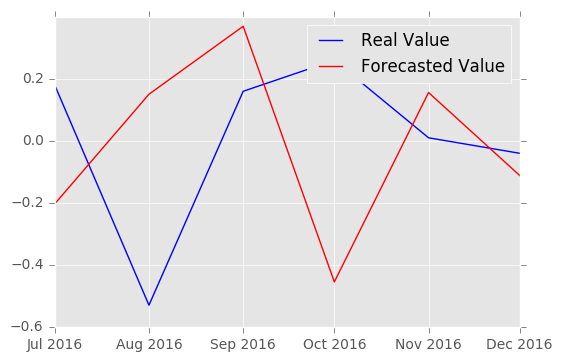

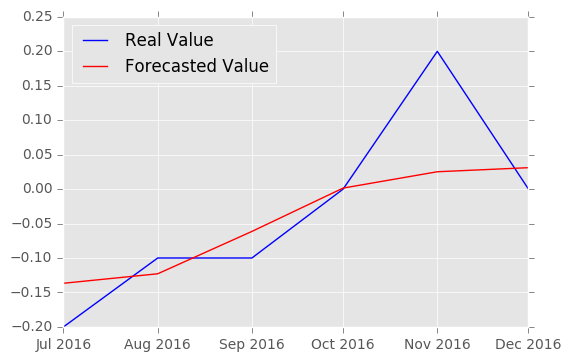

In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 2.8013747743832531, 'rmse': 1.6737307950752573, 'mae': 1.51327664476483}
{'mse': 0.092869416089735327, 'rmse': 0.30474483767528421, 'mae': 0.26518260856541803}
{'mse': 0.005208412562575402, 'rmse': 0.072169332562906544, 'mae': 0.070121355034855615}


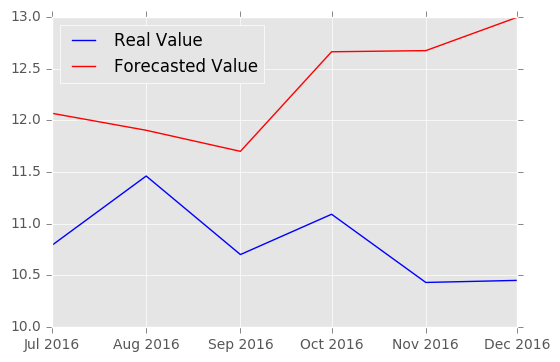

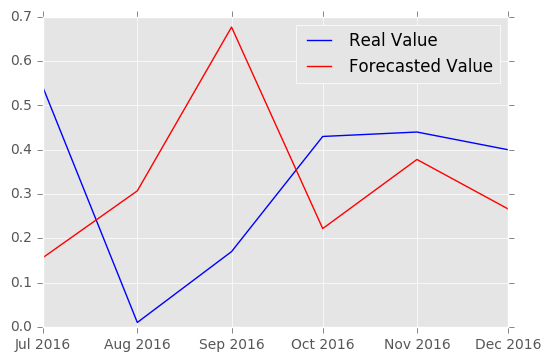

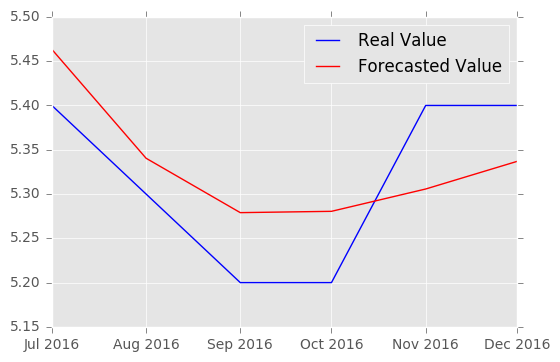

In [66]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid_full

In [67]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.0345
Epoch 2/500
0s - loss: 0.8148
Epoch 3/500
0s - loss: 0.7107
Epoch 4/500
0s - loss: 0.6188
Epoch 5/500
0s - loss: 0.5424
Epoch 6/500
0s - loss: 0.4802
Epoch 7/500
0s - loss: 0.4308
Epoch 8/500
0s - loss: 0.3964
Epoch 9/500
0s - loss: 0.3722
Epoch 10/500
0s - loss: 0.3545
Epoch 11/500
0s - loss: 0.3407
Epoch 12/500
0s - loss: 0.3295
Epoch 13/500
0s - loss: 0.3193
Epoch 14/500
0s - loss: 0.3124
Epoch 15/500
0s - loss: 0.3020
Epoch 16/500
0s - loss: 0.2939
Epoch 17/500
0s - loss: 0.2872
Epoch 18/500
0s - loss: 0.2794
Epoch 19/500
0s - loss: 0.2729
Epoch 20/500
0s - loss: 0.2670
Epoch 21/500
0s - loss: 0.2597
Epoch 22/500
0s - loss: 0.2553
Epoch 23/500
0s - loss: 0.2498
Epoch 24/500
0s - loss: 0.2441
Epoch 25/500
0s - loss: 0.2378
Epoch 26/500
0s - loss: 0.2325
Epoch 27/500
0s - loss: 0.2282
Epoch 28/500
0s - loss: 0.2247
Epoch 29/500
0s - loss: 0.2194
Epoch 30/500
0s - loss: 0.2143
Epoch 31/500
0s - loss: 0.2112
Epoch 32/500
0s - loss: 0.2067
Epoch 33/500
0s -

{'mse': 304.16829846633794, 'rmse': 17.440421395893448, 'mae': 16.191270123445967}
{'mse': 59.080121140797928, 'rmse': 7.6863594204797581, 'mae': 7.266283291556892}
{'mse': 0.29553260642366569, 'rmse': 0.5436291074102505, 'mae': 0.46886964850378449}


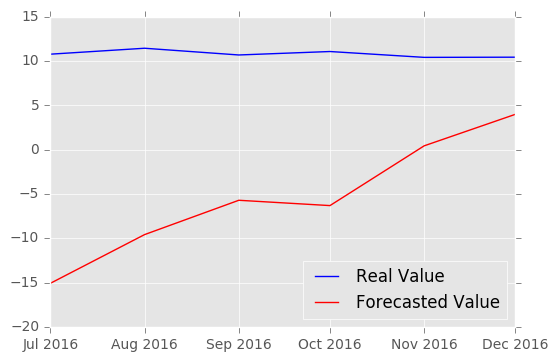

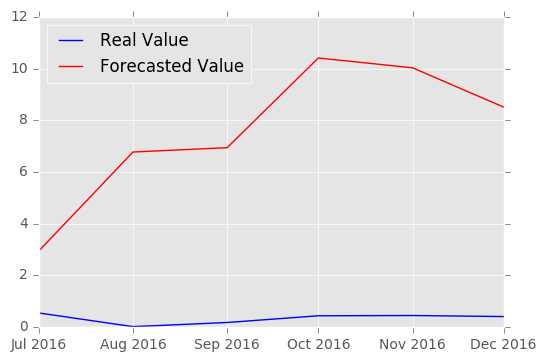

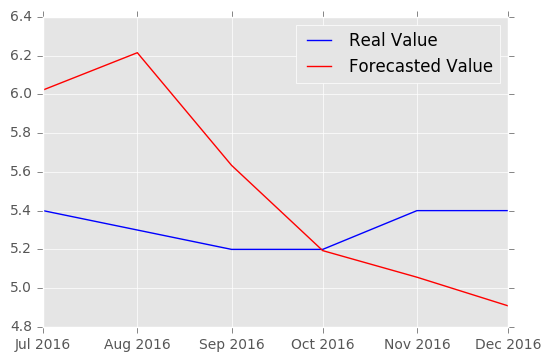

In [69]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [70]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.1902
Epoch 2/500
0s - loss: 0.8710
Epoch 3/500
0s - loss: 0.7466
Epoch 4/500
0s - loss: 0.6349
Epoch 5/500
0s - loss: 0.5442
Epoch 6/500
0s - loss: 0.4727
Epoch 7/500
0s - loss: 0.4246
Epoch 8/500
0s - loss: 0.3930
Epoch 9/500
0s - loss: 0.3697
Epoch 10/500
0s - loss: 0.3534
Epoch 11/500
0s - loss: 0.3421
Epoch 12/500
0s - loss: 0.3322
Epoch 13/500
0s - loss: 0.3225
Epoch 14/500
0s - loss: 0.3135
Epoch 15/500
0s - loss: 0.3054
Epoch 16/500
0s - loss: 0.3008
Epoch 17/500
0s - loss: 0.2941
Epoch 18/500
0s - loss: 0.2859
Epoch 19/500
0s - loss: 0.2824
Epoch 20/500
0s - loss: 0.2779
Epoch 21/500
0s - loss: 0.2748
Epoch 22/500
0s - loss: 0.2692
Epoch 23/500
0s - loss: 0.2663
Epoch 24/500
0s - loss: 0.2633
Epoch 25/500
0s - loss: 0.2595
Epoch 26/500
0s - loss: 0.2586
Epoch 27/500
0s - loss: 0.2546
Epoch 28/500
0s - loss: 0.2545
Epoch 29/500
0s - loss: 0.2514
Epoch 30/500
0s - loss: 0.2511
Epoch 31/500
0s - loss: 0.2460
Epoch 32/500
0s - loss: 0.2431
Epoch 33/500
0s -

{'mse': 480.20287449008339, 'rmse': 21.913531766698025, 'mae': 21.758842483696725}
{'mse': 38.298461740774378, 'rmse': 6.1885750977728611, 'mae': 6.1056549324433478}
{'mse': 0.3694042038565622, 'rmse': 0.60778631430508712, 'mae': 0.500168588811159}


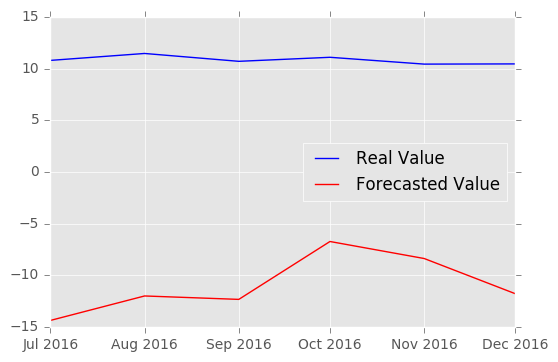

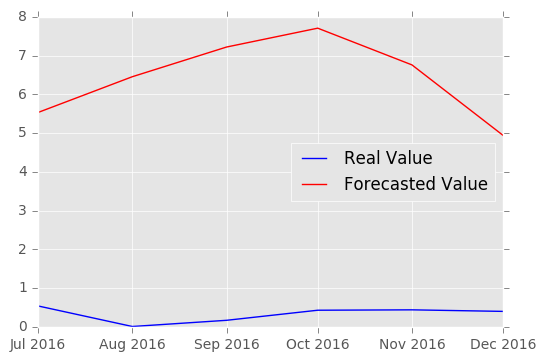

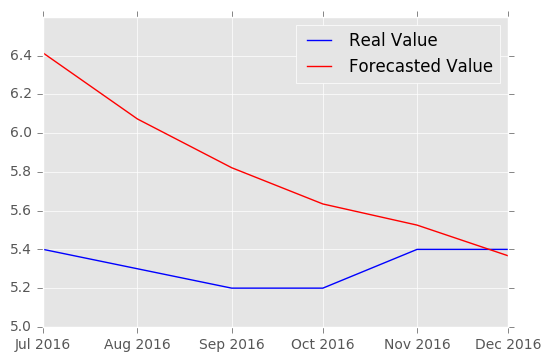

In [71]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [72]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.1022
Epoch 2/500
0s - loss: 1.0059
Epoch 3/500
0s - loss: 0.9913
Epoch 4/500
0s - loss: 0.9695
Epoch 5/500
0s - loss: 0.9482
Epoch 6/500
0s - loss: 0.9264
Epoch 7/500
0s - loss: 0.8631
Epoch 8/500
0s - loss: 0.8865
Epoch 9/500
0s - loss: 0.8550
Epoch 10/500
0s - loss: 0.8304
Epoch 11/500
0s - loss: 0.8239
Epoch 12/500
0s - loss: 0.8043
Epoch 13/500
0s - loss: 0.7852
Epoch 14/500
0s - loss: 0.7788
Epoch 15/500
0s - loss: 0.7995
Epoch 16/500
0s - loss: 0.8097
Epoch 17/500
0s - loss: 0.7751
Epoch 18/500
0s - loss: 0.7908
Epoch 19/500
0s - loss: 0.7429
Epoch 20/500
0s - loss: 0.7518
Epoch 21/500
0s - loss: 0.7501
Epoch 22/500
0s - loss: 0.7644
Epoch 23/500
0s - loss: 0.7766
Epoch 24/500
0s - loss: 0.7425
Epoch 25/500
0s - loss: 0.7835
Epoch 26/500
0s - loss: 0.7466
Epoch 27/500
0s - loss: 0.7268
Epoch 28/500
0s - loss: 0.7433
Epoch 29/500
0s - loss: 0.7381
Epoch 30/500
0s - loss: 0.7506
Epoch 31/500
0s - loss: 0.7235
Epoch 32/500
0s - loss: 0.7472
Epoch 33/500
0s -

{'mse': 429.05322156193625, 'rmse': 20.713599917975056, 'mae': 20.599762688882841}
{'mse': 11.106669978812926, 'rmse': 3.3326670969079593, 'mae': 3.2427026301920816}
{'mse': 0.46803036947847709, 'rmse': 0.68412745119493423, 'mae': 0.66492327108032745}


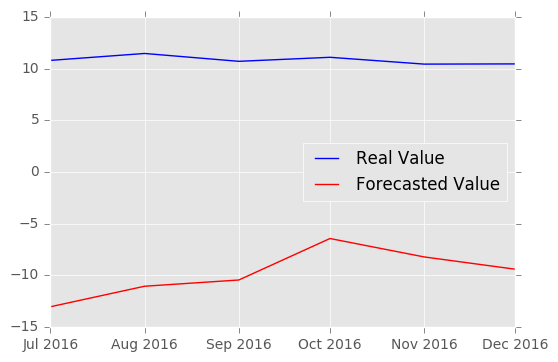

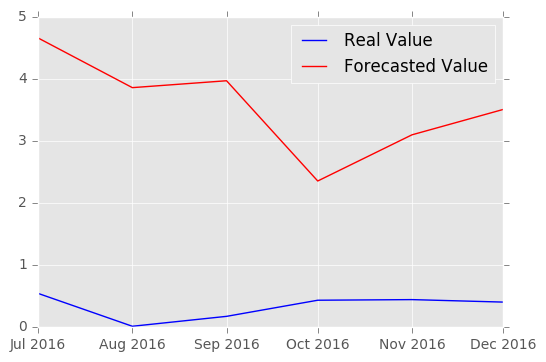

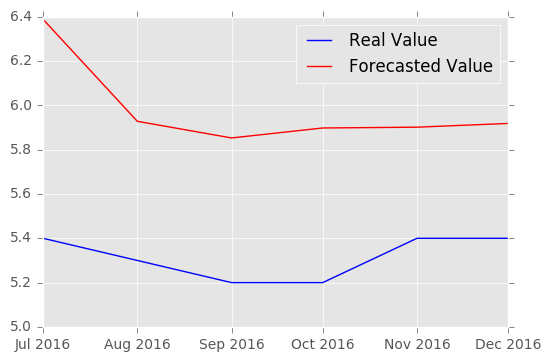

In [73]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])